# **Final Term Project: Predicting RUL of Lithium Ion Battery**
## **Group Members:**
* **Md Reza (eo9232@wayne.edu)**
* **Kirankumar Sivarajan (hj9424@wayne.edu)**

## **IE7860 - Winter 2022**

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
%matplotlib inline
import warnings; warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling1D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from keras.layers import Dense, Flatten, Conv2D,LeakyReLU

## **Load the NASA Battery Data**

In [2]:
%matplotlib inline
!pip show tensorflow
!wget -cq https://ti.arc.nasa.gov/c/5 -O naza.zip
!unzip -qqo naza.zip -d battery_data

Name: tensorflow
Version: 2.8.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: keras, gast, tf-estimator-nightly, protobuf, keras-preprocessing, wrapt, typing-extensions, libclang, termcolor, tensorboard, absl-py, flatbuffers, setuptools, h5py, tensorflow-io-gcs-filesystem, astunparse, opt-einsum, six, grpcio, google-pasta, numpy
Required-by: kapre


#### **Function to convert matlab to python Numpy format**

In [3]:
import scipy.io
import numpy as np, h5py
from datetime import datetime
import glob, os
import json
def convert_to_time(hmm):
	return datetime(year=int(hmm[0]),month=int(hmm[1]),day=int(hmm[2]), hour=int(hmm[3]),minute=int(hmm[4]),second=int(hmm[5]))

def loadMat(matfile):
	data = scipy.io.loadmat('battery_data/' + matfile)
	filename = matfile.split(".")[0]
	col = data[filename]
	col = col[0][0][0][0]
	size = col.shape[0]

	da = []

	for i in range(size):
		k=list(col[i][3][0].dtype.fields.keys())
		d1 = {}
		d2 = {}
		if str(col[i][0][0]) != 'impedance':
			for j in range(len(k)):
				t=col[i][3][0][0][j][0];
				l=[]
				for m in range(len(t)):
					l.append(t[m])
				d2[k[j]]=l
		d1['cycle']=str(col[i][0][0])
		d1['temp']=int(col[i][1][0])
		d1['time']=str(convert_to_time(col[i][2][0]))
		d1['data']=d2
		da.append(d1)

	return da

In [4]:
B0005 = loadMat('B0005.mat')
B0006 = loadMat('B0006.mat')
B0007 = loadMat('B0007.mat')
B0018 = loadMat('B0018.mat')

## **Some useful Functions for data preprocessing and plotting**

In [5]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

def getBatteryCapacity(Battery):
    cycle = []
    capacity = []
    i = 1
    for Bat in Battery:
        if Bat['cycle'] == 'discharge':
            cycle.append(i)
            capacity.append(Bat['data']['Capacity'][0])
            i += 1
    return [cycle, capacity]

def getChargingValues(Battery, Index):
    Battery = Battery[Index]['data']
    index = []
    i = 1
    for iterator in Battery['Voltage_measured']:
        index.append(i)
        i += 1
    return [index, Battery['Voltage_measured'], Battery['Current_measured'], Battery['Temperature_measured'], Battery['Voltage_charge'], Battery['Time']]

def getDischargingValues(Battery, Index):
    Battery = Battery[Index]['data']
    index = []
    i = 1
    for iterator in Battery['Voltage_measured']:
        index.append(i)
        i += 1
    return [index, Battery['Voltage_measured'], Battery['Current_measured'], Battery['Temperature_measured'], Battery['Voltage_load'], Battery['Time']]

def getMaxDischargeTemp(Battery):
    cycle = []
    temp = []
    i = 1
    for Bat in Battery:
        if Bat['cycle'] == 'discharge':
            cycle.append(i)
            temp.append(max(Bat['data']['Temperature_measured']))
            i += 1
    return [cycle, temp]

def getMaxChargeTemp(Battery, discharge_len):
    cycle = []
    temp = []
    i = 1
    for Bat in Battery:
        if Bat['cycle'] == 'charge':
            cycle.append(i)
            temp.append(max(Bat['data']['Temperature_measured']))
            i += 1
    return [cycle[:discharge_len], temp[:discharge_len]]

def getDataframe(Battery):
    l = getBatteryCapacity(Battery)
    l1 = getMaxDischargeTemp(Battery)
    l2 = getMaxChargeTemp(Battery, len(l1[0]))
    data = {'cycle':l[0],'capacity':l[1], 'max_discharge_temp':l1[1], 'max_charge_temp':l2[1]}
    return pd.DataFrame(data)

def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

def rollingAverage(x_stuff, y_stuff):
    window_size = 10
    sigma=1.0
    avg = moving_average(y_stuff, window_size)
    avg_list = avg.tolist()
    residual = y_stuff - avg
    testing_std = residual.rolling(window_size).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                  testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0].tolist()
    rolling_std
    std = np.std(residual)
    lst=[]
    lst_index = 0
    lst_count = 0
    for i in y_stuff.index:
        if (y_stuff[i] > avg_list[lst_index] + (1.5 * rolling_std[lst_index])) | (y_stuff[i] < avg_list[lst_index] - (1.5 * rolling_std[lst_index])):
            lt=[i,x_stuff[i], y_stuff[i],avg_list[lst_index],rolling_std[lst_index]]
            lst.append(lt)
            lst_count+=1
        lst_index+=1

    lst_x = []
    lst_y = []

    for i in range (0,len(lst)):
        lst_x.append(lst[i][1])
        lst_y.append(lst[i][2])

    return lst_x, lst_y

## **Exploratory Data Analysis (EDA)**

In [6]:
B0005_capacity = getBatteryCapacity(B0005)
B0006_capacity = getBatteryCapacity(B0006)
B0007_capacity = getBatteryCapacity(B0007)
B0018_capacity = getBatteryCapacity(B0018)

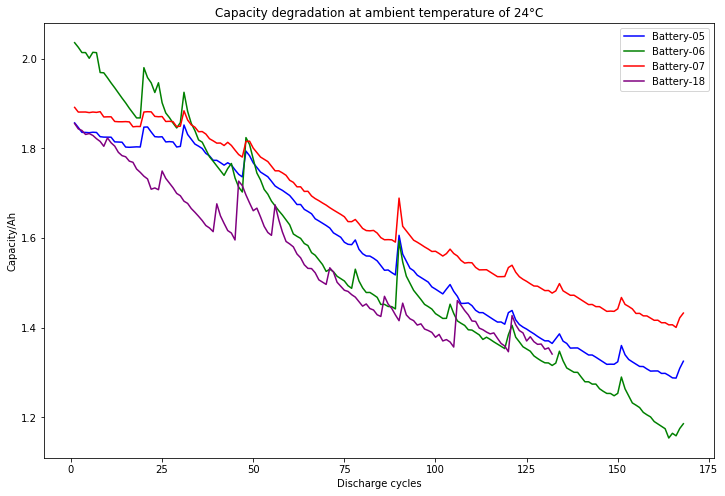

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.plot(B0005_capacity[0], B0005_capacity[1], color='blue', label='Battery-05')
ax.plot(B0006_capacity[0], B0006_capacity[1], color='green', label='Battery-06')
ax.plot(B0007_capacity[0], B0007_capacity[1], color='red', label='Battery-07')
ax.plot(B0018_capacity[0], B0018_capacity[1], color='purple', label='Battery-18')
ax.set(xlabel='Discharge cycles', ylabel='Capacity/Ah', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

In [8]:
B0005_charging = getChargingValues(B0005, 0)

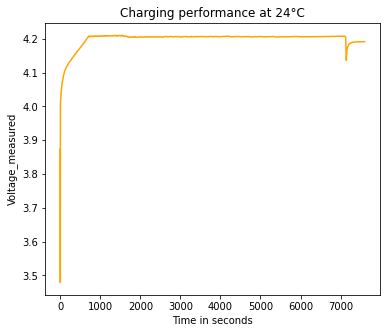

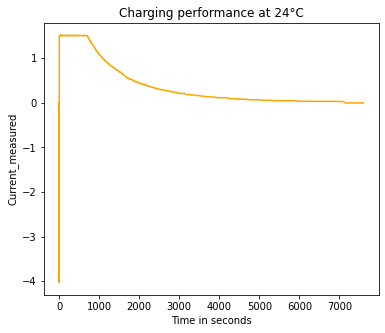

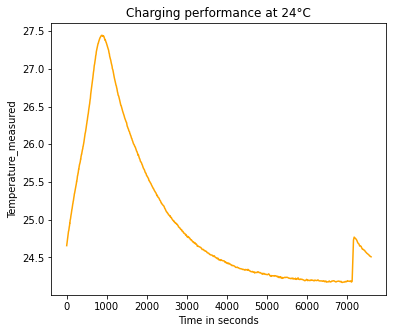

In [9]:
charging_labels = ['Voltage_measured','Current_measured','Temperature_measured']
indx = 1
for label in charging_labels:
    fig1, ax1 = plt.subplots(1, figsize=(6, 5))
 
    ax1.plot(B0005_charging[5], B0005_charging[indx], color='orange')
    ax1.set(xlabel='Time in seconds', ylabel=label, title='Charging performance at 24°C')
    indx += 1

In [10]:
B0005_charging_400 = getChargingValues(B0005, 400)

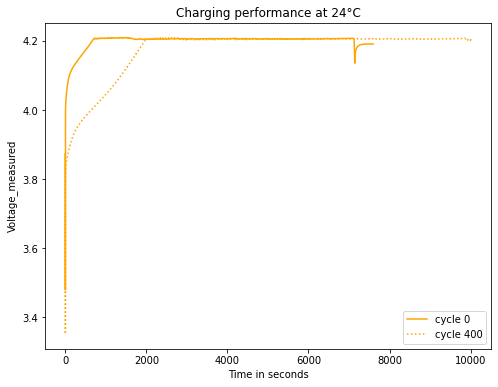

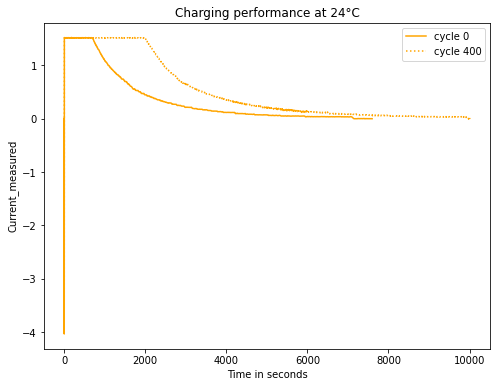

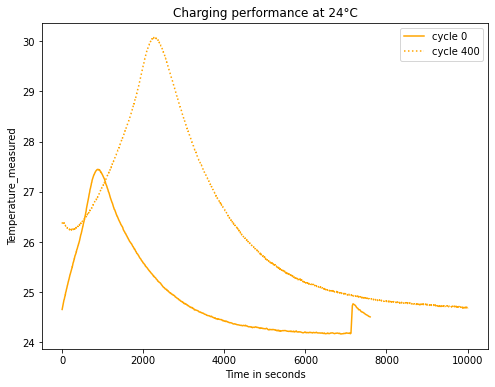

In [11]:
indx = 1
for label in charging_labels:
    fig1, ax1 = plt.subplots(1, figsize=(8, 6))
    ax1.plot(B0005_charging[5], B0005_charging[indx], color='orange', label='cycle 0')
    ax1.plot(B0005_charging_400[5], B0005_charging_400[indx], linestyle=':', color='orange', label='cycle 400')
    ax1.set(xlabel='Time in seconds', ylabel=label, title='Charging performance at 24°C')
   
    ax1.legend()

    
    indx += 1

In [12]:
B0005_discharging = getDischargingValues(B0005, 1)

In [13]:
discharging_labels = ['Voltage_measured','Current_measured','Temperature_measured']

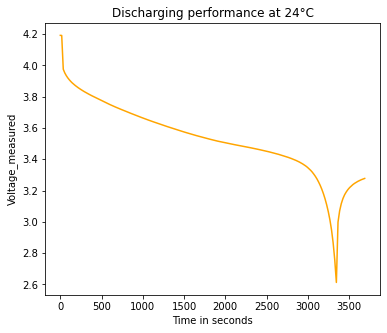

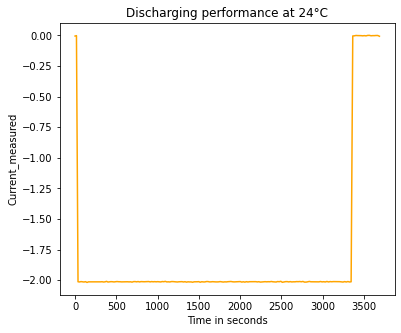

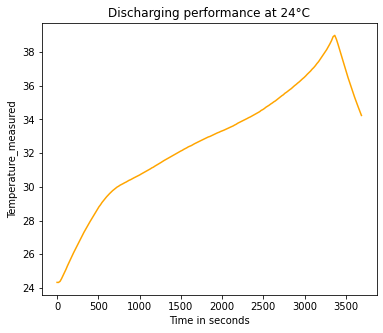

In [14]:
indx = 1
for label in discharging_labels:
    fig1, ax1 = plt.subplots(1, figsize=(6, 5))
   
    ax1.plot(B0005_discharging[5], B0005_discharging[indx], color='orange')
  

    ax1.set(xlabel='Time in seconds', ylabel=label, title='Discharging performance at 24°C')

    
    indx += 1

In [15]:
B0005_charging_400 = getChargingValues(B0005, 400)

In [16]:
B0005_discharging_402 = getDischargingValues(B0005, 402)

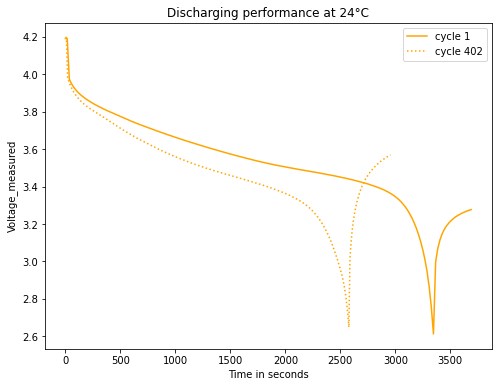

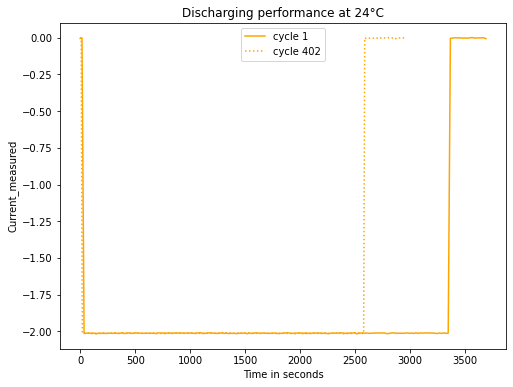

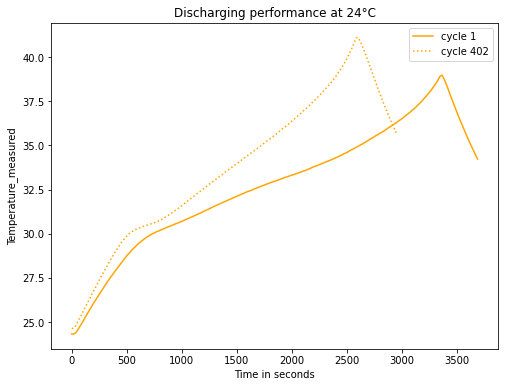

In [17]:
indx = 1
for label in charging_labels:
  
    fig1, ax1 = plt.subplots(1, figsize=(8, 6))

  
    ax1.plot(B0005_discharging[5], B0005_discharging[indx], color='orange', label='cycle 1')
    ax1.plot(B0005_discharging_402[5], B0005_discharging_402[indx], linestyle=':', color='orange', label='cycle 402')


    ax1.set(xlabel='Time in seconds', ylabel=label, title='Discharging performance at 24°C')

   
    ax1.legend()

    
    indx += 1

In [18]:
dfB0005 = getDataframe(B0005)

In [19]:
dfB0005.head(5)

,cycle,capacity,max_discharge_temp,max_charge_temp
0,1,1.856487,38.982181,27.445134
1,2,1.846327,39.033398,29.341949
2,3,1.835349,38.818797,29.553301
3,4,1.835263,38.762305,29.456340
4,5,1.834646,38.665393,29.481334


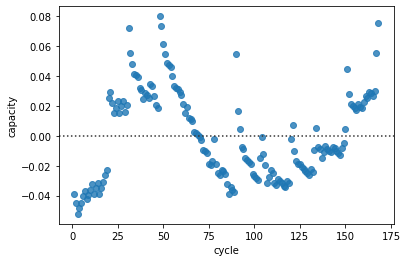

In [20]:
sns.residplot(dfB0005['cycle'], dfB0005['capacity'])

In [21]:
dfB0006 = getDataframe(B0006)
dfB0007 = getDataframe(B0007)
dfB0018 = getDataframe(B0018)

## **Anomaly Detection**

In [22]:
X = dfB0005['cycle'] 
Y = dfB0005['capacity']

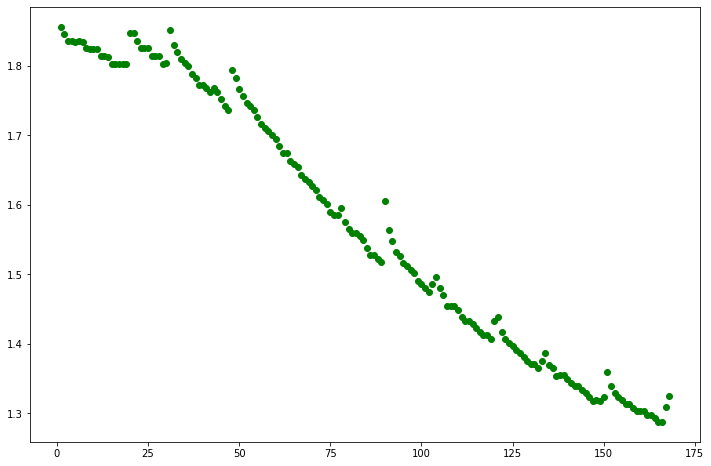

In [23]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.scatter(X, Y, color='green', label='Battery')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [25]:
lst_x, lst_y = rollingAverage(X_train, y_train)
d = {'X_train':X_train.values,'y_train':y_train.values}
d = pd.DataFrame(d)
d = d[~d['X_train'].isin(lst_x)]
X_train = d['X_train']
y_train = d['y_train']

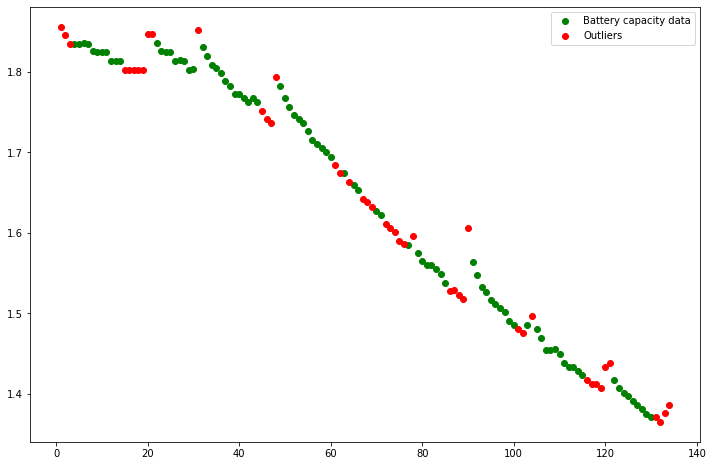

In [26]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.scatter(X_train, y_train, color='green', label='Battery capacity data')
ax.scatter(lst_x, lst_y, color='red', label='Outliers')
ax.legend()

# **LSTM, GRU, & RNN**

# **Model Building**

#### **Split training & test data**

In [27]:
def ConvertData(dataset,t_width):
    
    X_trains = []
    y_trains = []
    
    for df in dataset:
        t_length = len(dfB0005)

        train_x = np.arange(t_length)
        capacity = np.array(dfB0005['capacity'])
        train_y = capacity
        
        for i in range(t_length - t_width):
            X_trains.append(train_y[i:i + t_width])
            y_trains.append(train_y[i + t_width])

    X_trains = np.array(X_trains)
    y_trains = np.array(y_trains)
    
    return X_trains,y_trains

In [28]:
X_train,y_train = ConvertData([dfB0005, dfB0007, dfB0018],10)
X_test,y_test = ConvertData([dfB0006],10)

In [29]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(474, 10) (158, 10) (474,) (158,)


In [30]:
idx = np.arange(0,X_train.shape[0],1)
idx = np.random.permutation(idx)
idx_lim = idx[:500]

X_train = X_train[idx_lim]
y_train = y_train[idx_lim]

In [31]:
X_train = X_train.reshape([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.reshape([X_test.shape[0], X_test.shape[1], 1])
y_train = y_train.reshape([y_train.shape[0], 1])
y_test = y_test.reshape([y_test.shape[0], 1])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(474, 10, 1) (158, 10, 1) (474, 1) (158, 1)


In [32]:
!pip install livelossplot

     |████████████████████████████████| 793 kB 8.8 MB/s 
     |████████████████████████████████| 381 kB 45.0 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


## **LSTM**

## **Build & Compile The Model**

In [33]:
from keras.layers.core import Dense, Activation
length_of_sequence = X_train.shape[1]
in_out_neurons = 1
n_hidden = 3

model_LSTM = Sequential()
model_LSTM.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), 
               return_sequences=False,dropout=0))
model_LSTM.add(Dense(1))
model_LSTM.add(Activation("linear"))
model_LSTM.compile(loss="mean_squared_error", optimizer="rmsprop")

In [34]:
from livelossplot import PlotLossesKeras

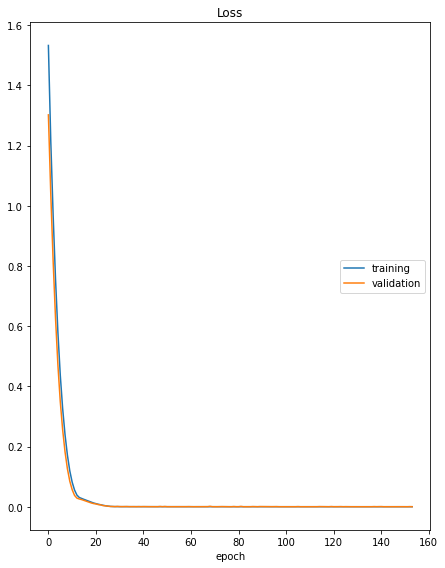

Loss
	training         	 (min:    0.000, max:    1.532, cur:    0.000)
	validation       	 (min:    0.000, max:    1.302, cur:    0.000)
15/15 [==============================] - 0s 26ms/step - loss: 2.5033e-04 - val_loss: 3.1170e-04
CPU times: user 1min 8s, sys: 14.7 s, total: 1min 23s
Wall time: 1min 15s


In [35]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
history_LSTM = model_LSTM.fit(X_train, y_train,
          batch_size=30,
          epochs=200,
          validation_split=0.1,
          callbacks=[early_stopping,PlotLossesKeras()]
          )

## **Evaluate The Model**

In [36]:
predicted_LSTM = model_LSTM.predict(X_train)
predicted_LSTM = predicted_LSTM.reshape(predicted_LSTM.shape[0])

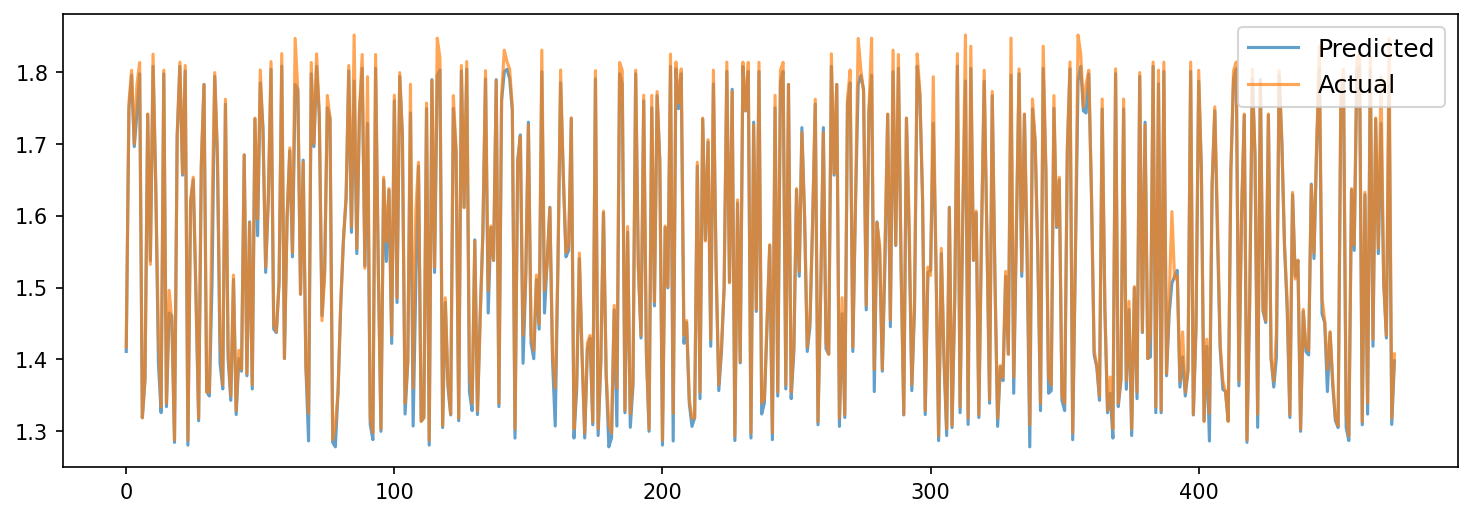

In [37]:
fig=plt.figure(figsize=(12, 4),dpi=150)
plt.plot(predicted_LSTM,alpha=0.7,label='Predicted')
plt.plot(y_train,alpha=0.7,label='Actual')
plt.legend(loc='upper right',fontsize=12)

In [38]:
predicted_LSTM = model_LSTM.predict(X_test[0:158])
predicted_LSTM = predicted_LSTM.reshape(predicted_LSTM.shape[0])

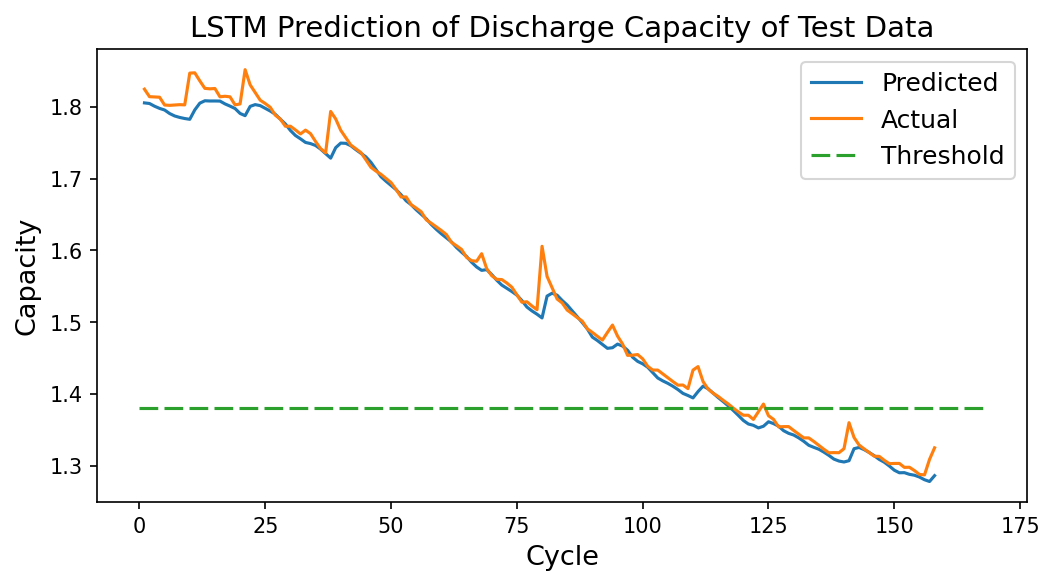

In [39]:
x_range = np.linspace(1,158,158)
fig=plt.figure(figsize=(8, 4),dpi=150)
plt.plot(x_range,predicted_LSTM,label='Predicted')
plt.plot(x_range,y_test[0:158],label='Actual')
plt.xlabel('Cycle',fontsize=13)
plt.ylabel('Capacity',fontsize=13)
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="Threshold")
plt.title('LSTM Prediction of Discharge Capacity of Test Data',fontsize=14)
plt.legend(loc='upper right',fontsize=12)

In [40]:
pred=0
Afil=0
Pfil=0
a=predicted_LSTM
b=y_test
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break

RULerror=Pfil-Afil

print('\x1b[1;03;30;1;95m' + 'LSTM - The Actual fail at cycle number: :\x1b[1;94m ', str(Afil))
print('\x1b[1;03;30;1;95m' + 'LSTM - The prediction fail at cycle number:\x1b[1;94m ', str(Pfil))
print('\x1b[1;03;30;1;95m' + 'LSTM - The error of RUL = \x1b[1;94m', str(RULerror) + '\x1b[1;03;30;1;95m' + ' Cycle(s) \x1b[1;94m ')

LSTM - The Actual fail at cycle number: :  117
LSTM - The prediction fail at cycle number:  118
LSTM - The error of RUL =  1 Cycle(s)  


In [41]:
from sklearn.metrics import mean_squared_error
mse_LSTM = mean_squared_error(y_test[0:158], predicted_LSTM)
print('\x1b[1;03;30;1;95m' + 'LSTM MSE:\x1b[1;94m ', '%.4f' % mse_LSTM)

LSTM MSE:  0.0003


In [42]:
from sklearn.metrics import r2_score
r2_LSTM = r2_score(y_test[0:158], predicted_LSTM)
print('\x1b[1;03;30;1;95m' + 'LSTM R-Squared Score:\x1b[1;94m ', '%.4f' % r2_LSTM)

LSTM R-Squared Score:  0.9907


# **GRU**

## **Build & Compile The Model**

In [43]:
from keras.layers.core import Dense, Activation
length_of_sequence = X_train.shape[1]
in_out_neurons = 1
n_hidden = 3

model_GRU = Sequential()
model_GRU.add(GRU(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), 
               return_sequences=False,dropout=0))
model_GRU.add(Dense(1))
model_GRU.add(Activation("linear"))
model_GRU.compile(loss="mean_squared_error", optimizer="rmsprop")

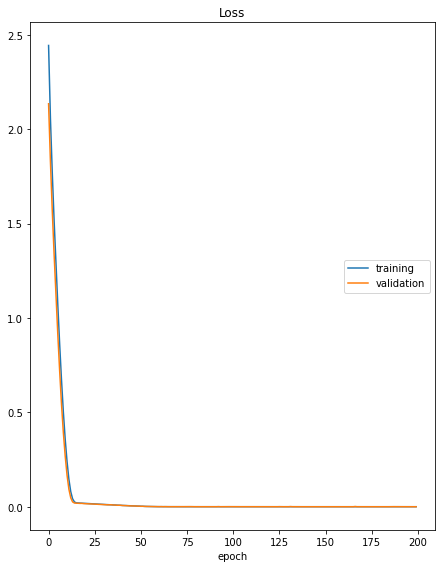

Loss
	training         	 (min:    0.000, max:    2.444, cur:    0.000)
	validation       	 (min:    0.000, max:    2.135, cur:    0.000)
15/15 [==============================] - 0s 25ms/step - loss: 2.9734e-04 - val_loss: 2.3095e-04
CPU times: user 1min 21s, sys: 21.6 s, total: 1min 43s
Wall time: 1min 23s


In [44]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
history_GRU = model_GRU.fit(X_train, y_train,
          batch_size=30,
          epochs=200,
          validation_split=0.1,
          callbacks=[early_stopping,PlotLossesKeras()]
          )

## **Evaluate The Model**

In [45]:
predicted_GRU = model_GRU.predict(X_train)
predicted_GRU = predicted_GRU.reshape(predicted_GRU.shape[0])

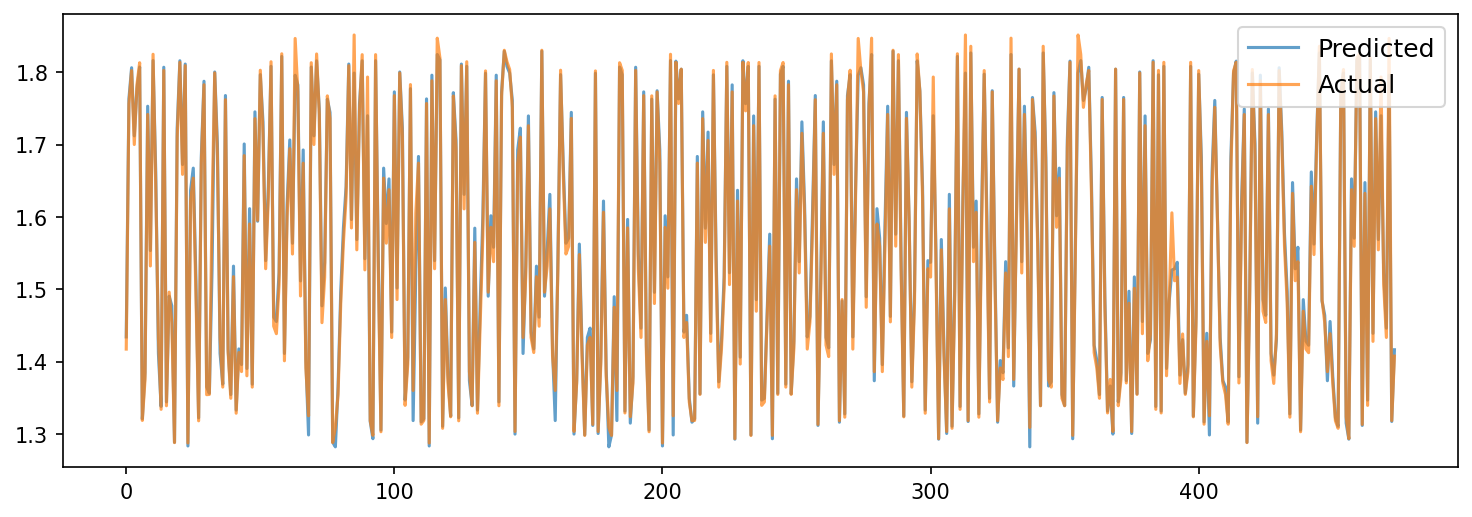

In [46]:
fig=plt.figure(figsize=(12, 4),dpi=150)
plt.plot(predicted_GRU,alpha=0.7,label='Predicted')
plt.plot(y_train,alpha=0.7,label='Actual')
plt.legend(loc='upper right',fontsize=12)

In [47]:
predicted_GRU = model_GRU.predict(X_test[0:158])
predicted_GRU = predicted_GRU.reshape(predicted_GRU.shape[0])

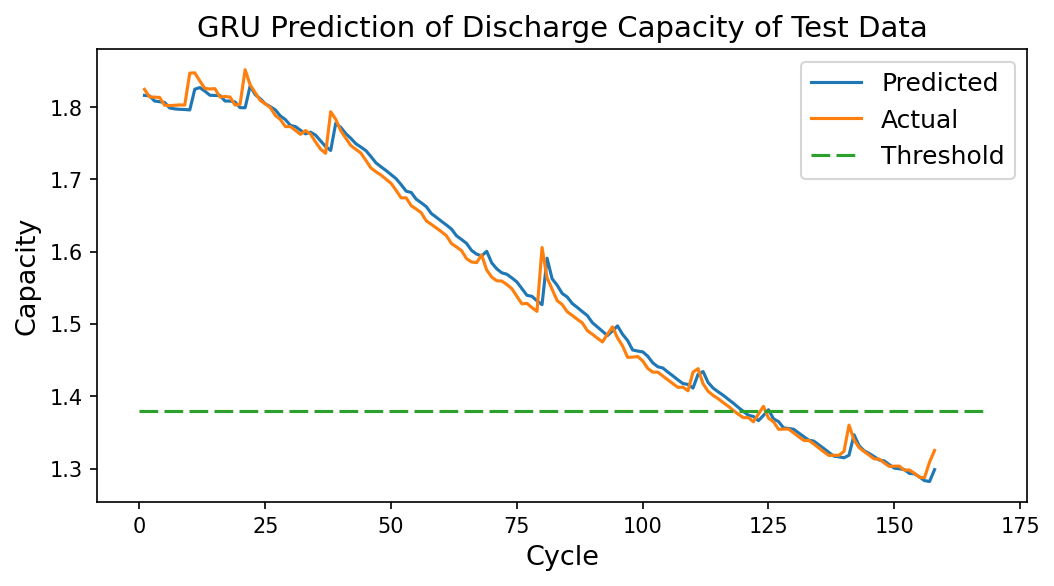

In [48]:
x_range = np.linspace(1,158,158)
fig=plt.figure(figsize=(8, 4),dpi=150)
plt.plot(x_range,predicted_GRU,label='Predicted')
plt.plot(x_range,y_test[0:158],label='Actual')
plt.xlabel('Cycle',fontsize=13)
plt.ylabel('Capacity',fontsize=13)
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="Threshold")
plt.title('GRU Prediction of Discharge Capacity of Test Data',fontsize=14)
plt.legend(loc='upper right',fontsize=12)

In [49]:
pred=0
Afil=0
Pfil=0
a=predicted_GRU
b=y_test
j=0
k=0

for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break

RULerror=Pfil-Afil

print('\x1b[1;03;30;1;95m' + 'GRU - The Actual fail at cycle number: :\x1b[1;94m ', str(Afil))
print('\x1b[1;03;30;1;95m' + 'GRU - The prediction fail at cycle number:\x1b[1;94m ', str(Pfil))
print('\x1b[1;03;30;1;95m' + 'GRU - The error of RUL = \x1b[1;94m', str(RULerror) + '\x1b[1;03;30;1;95m' + ' Cycle(s) \x1b[1;94m ')

GRU - The Actual fail at cycle number: :  119
GRU - The prediction fail at cycle number:  118
GRU - The error of RUL =  -1 Cycle(s)  


In [50]:
from sklearn.metrics import mean_squared_error
mse_GRU = mean_squared_error(y_test[0:158], predicted_GRU)
print('\x1b[1;03;30;1;95m' + 'GRU MSE:\x1b[1;94m ', '%.4f' % mse_GRU)

GRU MSE:  0.0002


In [51]:
from sklearn.metrics import r2_score
r2_GRU = r2_score(y_test[0:158], predicted_GRU)
print('\x1b[1;03;30;1;95m' + 'GRU R-Squared Score:\x1b[1;94m ', '%.4f' % r2_GRU)

GRU R-Squared Score:  0.9930


# **RNN**

## **Build & Compile The Model**

In [52]:
from keras.layers.core import Dense, Activation
length_of_sequence = X_train.shape[1]
in_out_neurons = 1
n_hidden = 3

model_RNN = Sequential()
model_RNN.add(SimpleRNN(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), 
               return_sequences=False,dropout=0))
model_RNN.add(Dense(1))
model_RNN.add(Activation("linear"))
model_RNN.compile(loss="mean_squared_error", optimizer="rmsprop")

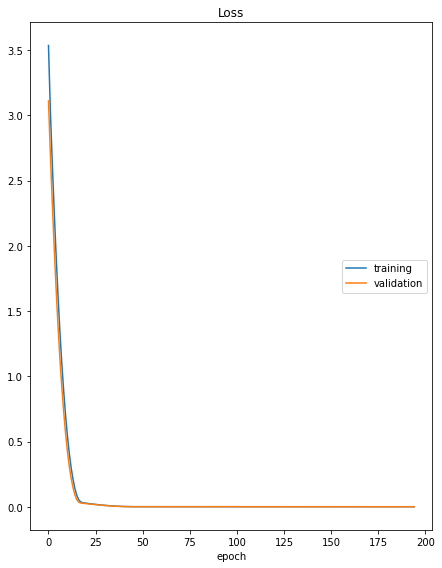

Loss
	training         	 (min:    0.000, max:    3.535, cur:    0.000)
	validation       	 (min:    0.000, max:    3.110, cur:    0.000)
15/15 [==============================] - 0s 23ms/step - loss: 2.8012e-04 - val_loss: 3.3124e-04
CPU times: user 1min 11s, sys: 20.5 s, total: 1min 32s
Wall time: 1min 10s


In [53]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
history_RNN = model_RNN.fit(X_train, y_train,
          batch_size=30,
          epochs=200,
          validation_split=0.1,
          callbacks=[early_stopping,PlotLossesKeras()]
          )

## **Evaluate The Model**

In [54]:
predicted_RNN = model_RNN.predict(X_train)
predicted_RNN = predicted_RNN.reshape(predicted_RNN.shape[0])

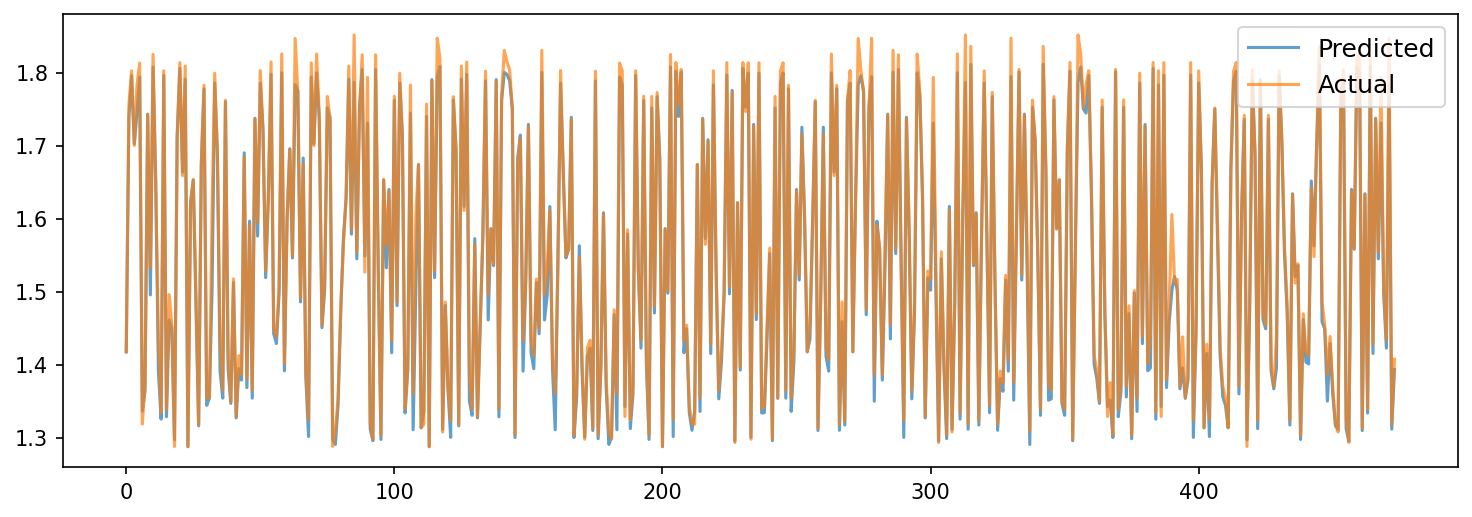

In [55]:
fig=plt.figure(figsize=(12, 4),dpi=150)
plt.plot(predicted_RNN,alpha=0.7,label='Predicted')
plt.plot(y_train,alpha=0.7,label='Actual')
plt.legend(loc='upper right',fontsize=12)

In [56]:
predicted_RNN = model_RNN.predict(X_test[0:158])
predicted_RNN = predicted_RNN.reshape(predicted_RNN.shape[0])

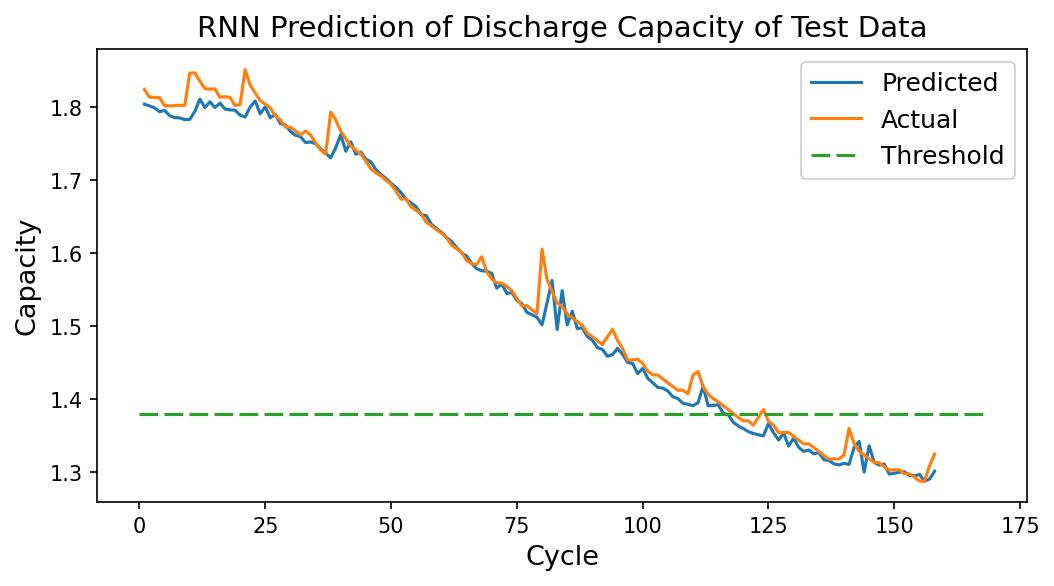

In [57]:
x_range = np.linspace(1,158,158)
fig=plt.figure(figsize=(8, 4),dpi=150)
plt.plot(x_range,predicted_RNN,label='Predicted')
plt.plot(x_range,y_test[0:158],label='Actual')
plt.xlabel('Cycle',fontsize=13)
plt.ylabel('Capacity',fontsize=13)
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="Threshold")
plt.title('RNN Prediction of Discharge Capacity of Test Data',fontsize=14)
plt.legend(loc='upper right',fontsize=12)

In [58]:
pred=0
Afil=0
Pfil=0
a=predicted_RNN
b=y_test
j=0
k=0

for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break

RULerror=Pfil-Afil

print('\x1b[1;03;30;1;95m' + 'RNN - The Actual fail at cycle number: :\x1b[1;94m ', str(Afil))
print('\x1b[1;03;30;1;95m' + 'RNN - The prediction fail at cycle number:\x1b[1;94m ', str(Pfil))
print('\x1b[1;03;30;1;95m' + 'RNN - The error of RUL = \x1b[1;94m', str(RULerror) + '\x1b[1;03;30;1;95m' + ' Cycle(s) \x1b[1;94m ')

RNN - The Actual fail at cycle number: :  116
RNN - The prediction fail at cycle number:  118
RNN - The error of RUL =  2 Cycle(s)  


In [59]:
from sklearn.metrics import mean_squared_error
mse_RNN = mean_squared_error(y_test[0:158], predicted_RNN)
print('\x1b[1;03;30;1;95m' + 'RNN MSE:\x1b[1;94m ', '%.4f' % mse_RNN)

RNN MSE:  0.0004


In [60]:
from sklearn.metrics import r2_score
r2_RNN = r2_score(y_test[0:158], predicted_RNN)
print('\x1b[1;03;30;1;95m' + 'RNN R-Squared Score:\x1b[1;94m ', '%.4f' % r2_RNN)

RNN R-Squared Score:  0.9894


# **Model Performance Comparisons**

In [61]:
#Create Dataframe for Models' MSE
MSE = pd.DataFrame().append({'Model Name':'LSTM', 'MSE': mse_LSTM}, ignore_index=True)
MSE = MSE.append({'Model Name':'RNN', 'MSE': mse_RNN}, ignore_index=True)
MSE = MSE.append({'Model Name':'GRU', 'MSE': mse_GRU}, ignore_index=True)

#Create Dataframe for Models' R-Squared Score
R2 = pd.DataFrame().append({'Model Name':'LSTM', 'R2-Score':r2_LSTM}, ignore_index=True)
R2 = R2.append({'Model Name':'RNN', 'R2-Score':r2_RNN}, ignore_index=True)
R2 = R2.append({'Model Name':'GRU', 'R2-Score':r2_GRU}, ignore_index=True)

Models' Mean Squared Error Compared:
+----+--------------+-------------+
|    | Model Name   |         MSE |
|----+--------------+-------------|
|  0 | GRU          | 0.00023712  |
|  1 | LSTM         | 0.000314476 |
|  2 | RNN          | 0.000358273 |
+----+--------------+-------------+ 

Models' R-Squared Score Compared:
+----+--------------+------------+
|    | Model Name   |   R2-Score |
|----+--------------+------------|
|  0 | GRU          |   0.992957 |
|  1 | LSTM         |   0.990659 |
|  2 | RNN          |   0.989358 |
+----+--------------+------------+ 



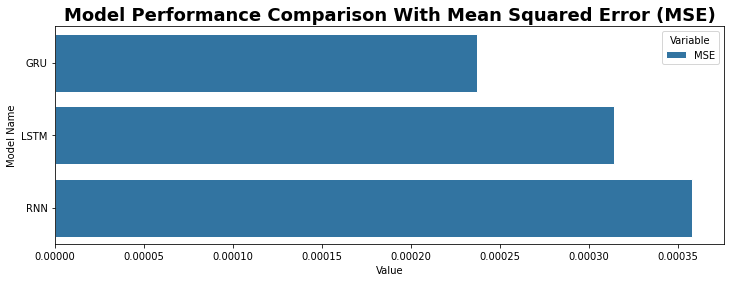

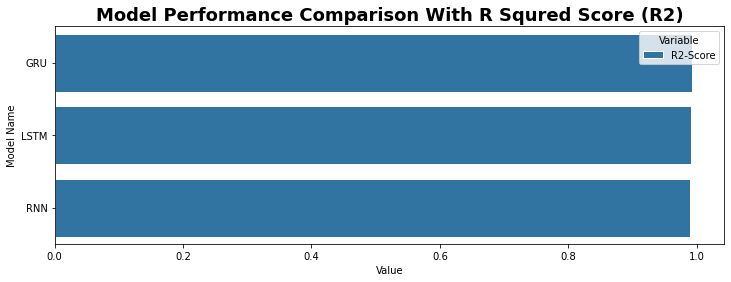

In [62]:
#Plot the comparision chart
from tabulate import tabulate
print('\x1b[1;03;30;1;95m' + "Models' Mean Squared Error Compared:\x1b[1;94m")
MSE = MSE.sort_values('MSE', ascending=True)
MSE.reset_index(drop=True, inplace=True)
print(tabulate(MSE, headers = 'keys', tablefmt = 'psql'),"\n")


fig, ax = plt.subplots(figsize=(12, 4))
tbl = MSE.melt(id_vars='Model Name').rename(columns=str.title)
sns.barplot(y='Model Name', x='Value', hue='Variable', data=tbl, ax=ax, palette='tab10', linewidth=1, edgecolor="w")
cmp=plt.title('Model Performance Comparison With Mean Squared Error (MSE)', weight='bold').set_fontsize('18')

print('\x1b[1;03;30;1;95m' + "Models' R-Squared Score Compared:\x1b[1;94m")
R2 = R2.sort_values('R2-Score', ascending=False)
R2.reset_index(drop=True, inplace=True)
print(tabulate(R2, headers = 'keys', tablefmt = 'psql'),"\n")

fig, ax = plt.subplots(figsize=(12, 4))
tbl = R2.melt(id_vars='Model Name').rename(columns=str.title)
sns.barplot(y='Model Name', x='Value', hue='Variable', data=tbl, ax=ax, palette='tab10', linewidth=1, edgecolor="w")
cmp=plt.title('Model Performance Comparison With R Squred Score (R2)', weight='bold').set_fontsize('18')

# **Explainable AI with SHAP**

## **Prepare The Data**

In [63]:
df = getDataframe(B0005)

X = df.loc[:, df.columns != 'capacity']
y = df.loc[:, 'capacity']
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y,test_size=0.2,random_state=0)

## **Build & Compile The Model**

In [64]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
regressor = ensemble.RandomForestRegressor()
regressor.fit(X_train_s, y_train_s);

In [65]:
!pip install shap

     |████████████████████████████████| 564 kB 6.8 MB/s 


## **Calculate SHAP Values**

In [66]:
import shap

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train_s)

## **SHAP Values Plot:**
#### **Help in analyzing & understanding the model.**

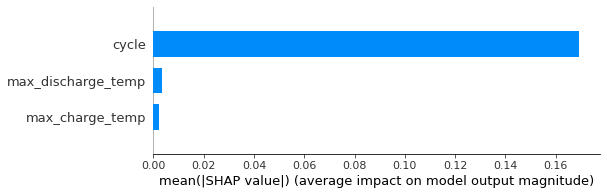

In [67]:
shap.summary_plot(shap_values, X_train_s.values, plot_type="bar", class_names= y_train_s, feature_names = X_train_s.columns)

## **SHAP Summary Plot:**
#### **Combines feature importance with feature effects.**

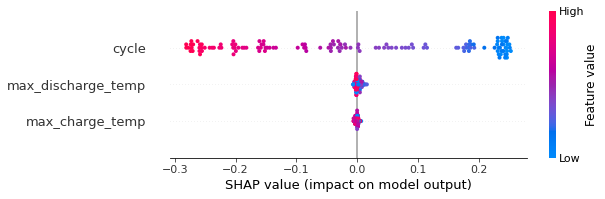

In [68]:
shap.summary_plot(shap_values, X_train_s, feature_names=X_train_s.columns)

## **SHAP Decision Plot:** 
#### **Shows the important features involved in a model’s output.**

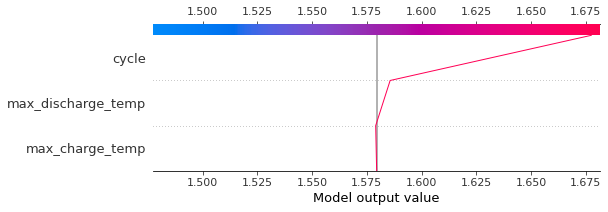

In [69]:
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names = list(X_test_s))

## **SHAP Force Plot:**
#### **Help with the explainability of a single model prediction.**

In [70]:
shap.initjs()
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], X_test_s.values[i], feature_names = X_test_s.columns)